In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [4]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import numpy as np
import pandas as pd

## Prepare data

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
DATASET_MAPPINGS = {
    "zvuk": {"kaggle": "alexxl/zvuk-dataset", "file": "zvuk-interactions.parquet"},
    "megamarket": {"kaggle": "alexxl/megamarket", "file": "megamarket.parquet"},
}
data_path = "replay_benchmarks/data/"
kaggle_info = DATASET_MAPPINGS['zvuk']
raw_data_file = os.path.join(data_path, kaggle_info["file"])

"""Download dataset from Kaggle."""
kaggle_dataset = kaggle_info["kaggle"]

os.environ.setdefault("KAGGLE_USERNAME", "recsysaccelerate")
os.environ.setdefault("KAGGLE_KEY", "6363e91b656fea576c39e4f55dcc1d00")

api = KaggleApi()
api.authenticate()

api.dataset_download_files(kaggle_dataset, path=data_path, unzip=True)
print(f"Dataset downloaded and extracted to {data_path}")

interactions = pd.read_parquet(raw_data_file)
interactions['timestamp'] = interactions[
    'datetime'
].astype("int64")

interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

In [9]:
interactions.head()

,user_id,session_id,datetime,item_id,play_duration,timestamp
0,1938823,2200336,2023-03-18 11:43:57.856,1242546,23.999992,1679139837856
1,1938823,2200336,2023-03-18 11:43:58.114,145031,2.000000,1679139838114
2,1938823,2200336,2023-03-18 11:45:12.932,145031,34.000000,1679139912932
3,1938823,2200336,2023-03-18 11:45:27.808,1501837,18.000000,1679139927808
4,1938823,2200336,2023-03-18 11:45:42.891,1402020,2.000000,1679139942891


In [10]:
interactions['play_duration'].describe()

count    2.446736e+08
mean     1.019550e+02
std      6.624570e+02
min     -8.553478e+06
25%      2.999992e+00
50%      7.800000e+01
75%      1.870000e+02
max      7.186000e+03
Name: play_duration, dtype: float64

In [11]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 382790
Number of unique items: 1506950


In [14]:
pd.to_datetime(interactions['timestamp'], unit='ms').describe()

count                        244673551
mean     2023-03-18 19:10:19.420445184
min         2023-01-15 00:00:00.074000
25%      2023-02-17 04:49:50.308499968
50%      2023-03-21 02:40:40.248999936
75%      2023-04-18 03:36:02.437499904
max         2023-05-14 20:59:59.994000
Name: timestamp, dtype: object

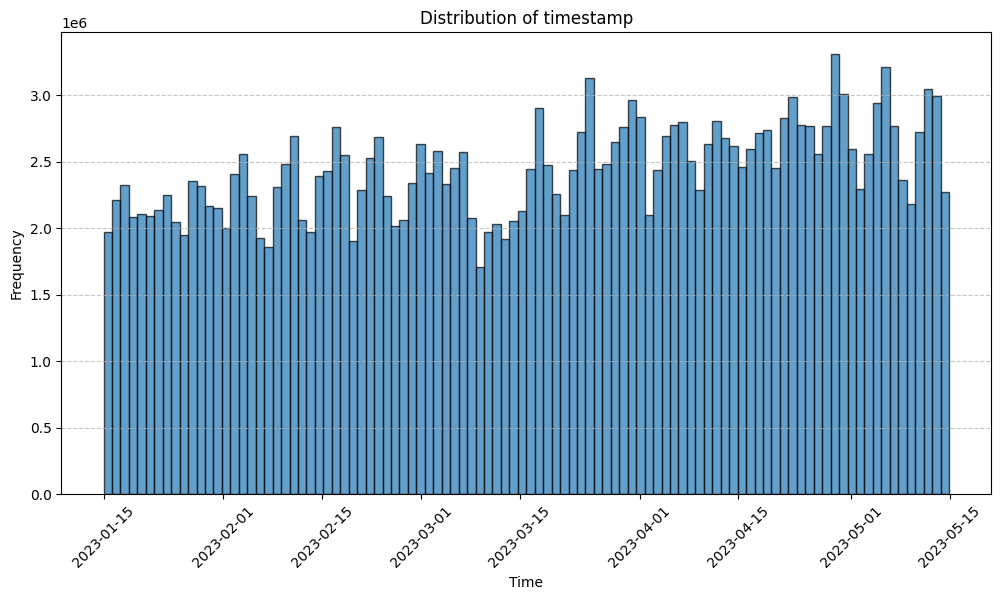

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ms', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [16]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [17]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 370528
Number of unique items: 893022


In [ ]:
# Number of unique users: 382790
# Number of unique items: 1506950

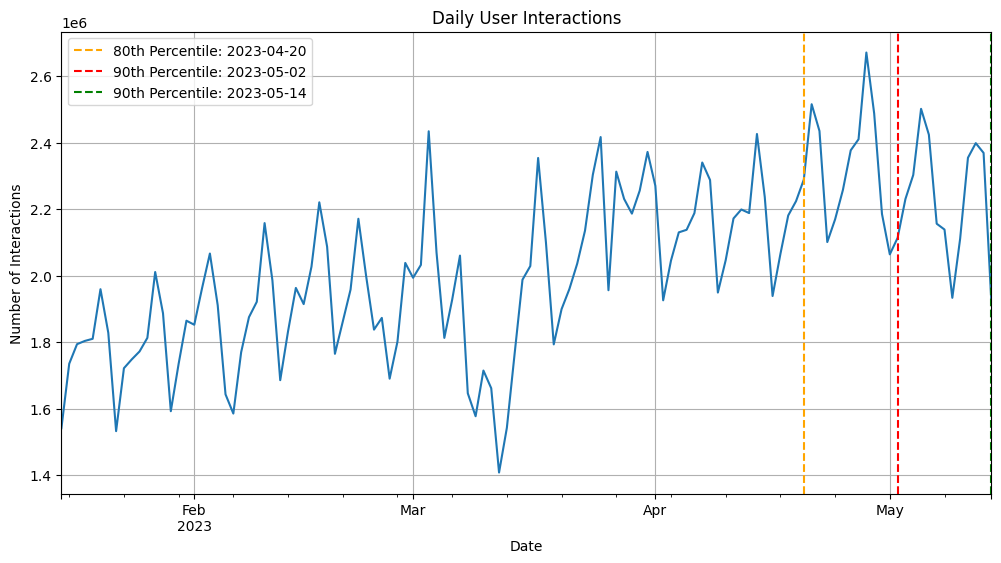

In [18]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ms')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'90th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    146297.000000
mean        138.037909
std         310.040379
min           1.000000
25%          17.000000
50%          61.000000
75%         166.000000
max       70107.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    144926.000000
mean        147.190477
std         317.440979
min           1.000000
25%          19.000000
50%          66.000000
75%         177.000000
max       74424.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    146297.000000
mean         86.358346
std          75.090638
min           1.000000
25%          17.000000
50%          61.000000
75%         166.000000
max         200.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    144926.000000
mean         89.446573
std          75.772727
min           1.000000
25%          19.000000
50%          66.000000
75%         177.000000
max         200.0

In [20]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [21]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [22]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 868866
Number of unique query_ids: 146297


count    146297.000000
mean       1071.165601
std        1726.520091
min           1.000000
25%         152.000000
50%         504.000000
75%        1304.000000
max      123811.000000
Name: item_id_seq, dtype: float64

In [23]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 472359
Number of unique query_ids: 146297


count    146297.000000
mean         86.358346
std          75.090638
min           1.000000
25%          17.000000
50%          61.000000
75%         166.000000
max         200.000000
Name: item_id_seq, dtype: float64

In [24]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 870462
Number of unique query_ids: 144926


count    144926.000000
mean       1195.235706
std        1883.810956
min           1.000000
25%         192.000000
50%         583.000000
75%        1453.000000
max      128592.000000
Name: item_id_seq, dtype: float64

In [25]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe()

Number of unique item_ids: 473253
Number of unique query_ids: 144926


count    144926.000000
mean         89.446573
std          75.772727
min           1.000000
25%          19.000000
50%          66.000000
75%         177.000000
max         200.000000
Name: item_id, dtype: float64

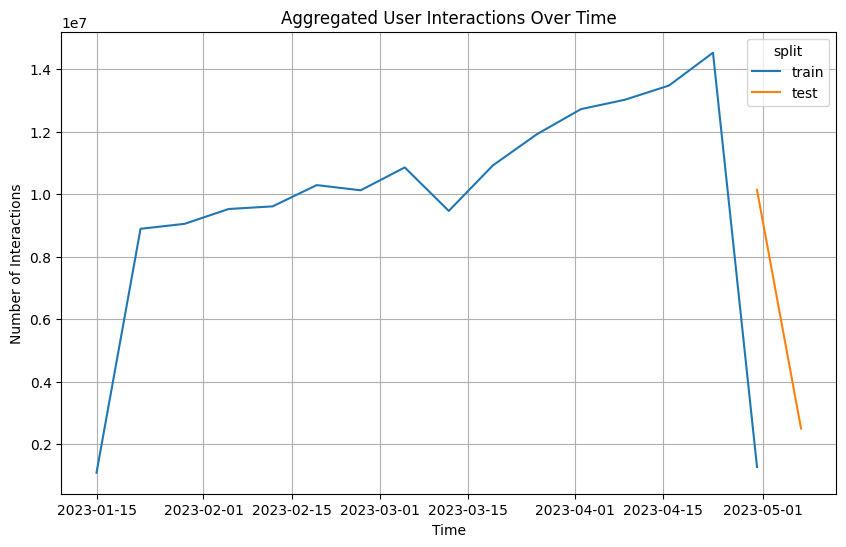

In [26]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

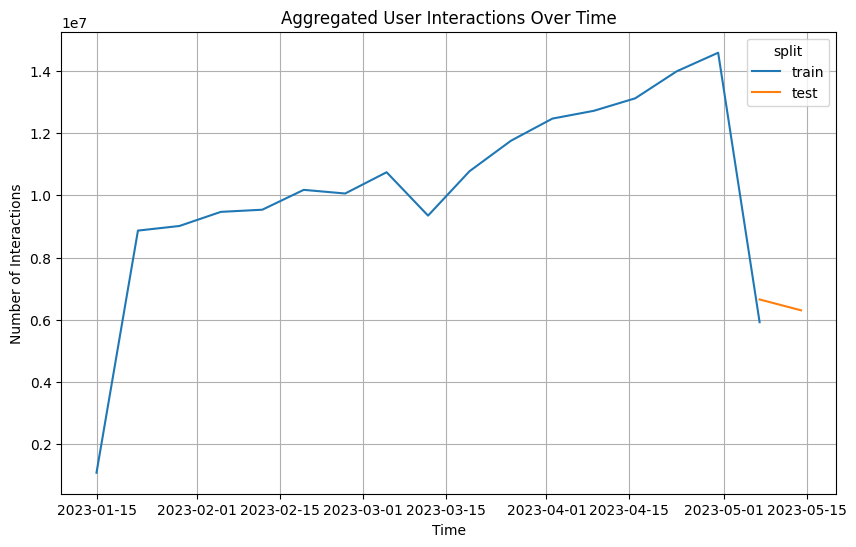

In [27]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

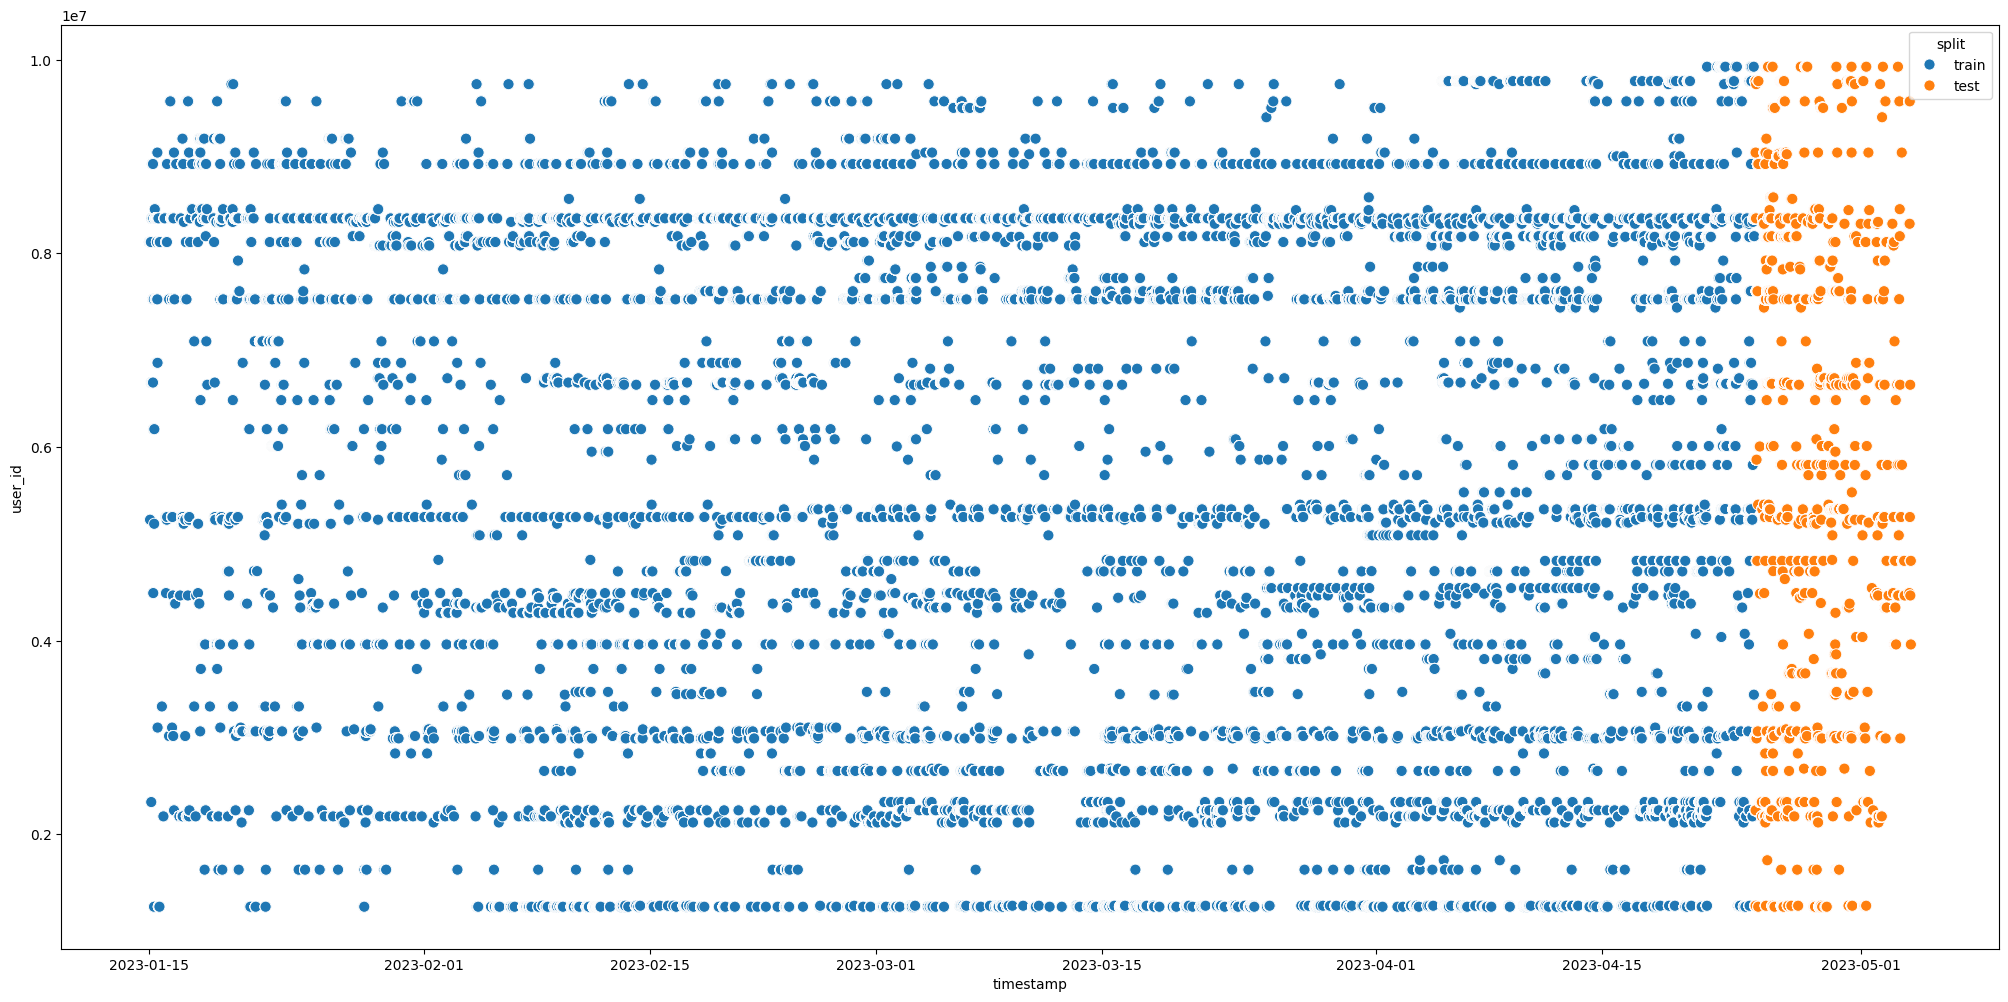

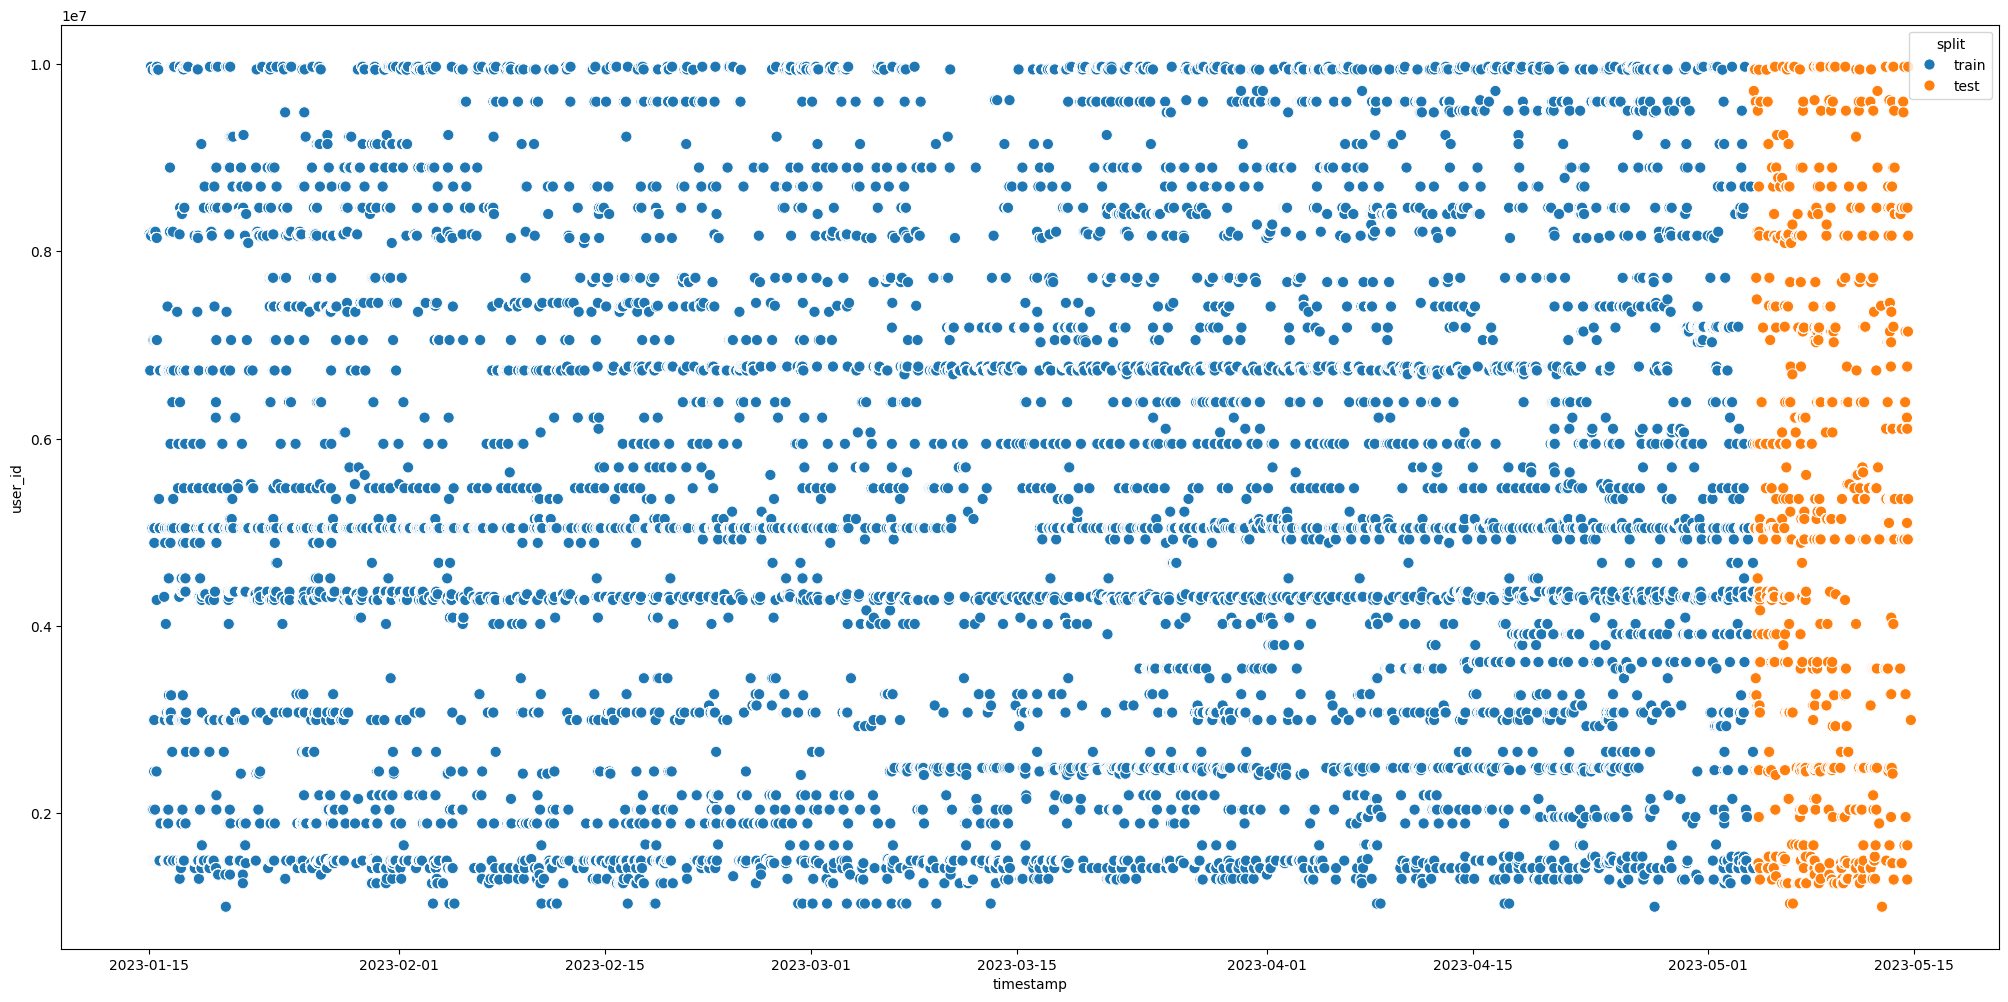

In [28]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)